In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
dep_var_name = 'Murder and nonnegligent manslaughter'

In [3]:
#read in
all_df = pd.read_csv('data/derived/crime_ACS_merged.csv', index_col=0)
print(all_df.shape)
all_df.columns  # [:20]
all_df.head(3)

(350, 566)


,Aggravated assault,Burglary,Counties/principal cities,Forcible rape,Larceny- theft,Larceny-theft,Larceny‑ theft,Motor vehicle theft,Murder and nonnegligent manslaughter,Population,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
6,121.0,563.3,"Rate per 100,000 inhabitants",NaN,1857.3,NaN,NaN,144.0,6.0,NaN,...,19.0,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
30,NaN,264.7,"Rate per 100,000 inhabitants",NaN,NaN,NaN,NaN,89.1,2.6,NaN,...,24.8,5.8,11.6,10.2,12.1,10.4,10.7,11.6,2.0,0.9
36,413.7,761.3,"Rate per 100,000 inhabitants",NaN,2781.3,NaN,NaN,390.2,5.3,NaN,...,5.7,6.5,17.4,18.2,14.4,11.6,7.9,12.7,4.7,1.0


In [4]:
#Non-numeric columns & missing dependent variable

#TODO: un-hackify this
#all columns to numeric
for col in all_df.columns.values:
    all_df.loc[:, col] = pd.to_numeric(all_df[col], errors='coerce')

#drop columns with many NaN (likely those that were text data)
bad_cols = all_df.isnull().sum() > 100
all_df = all_df.loc[:, ~bad_cols]


#deal with missing dependent variable (by dropping those rows)
missing_dv = all_df[dep_var_name].isnull()
all_df = all_df.loc[~missing_dv, :]

print(all_df.shape)
all_df.head()

(342, 416)


,Aggravated assault,Burglary,Motor vehicle theft,Murder and nonnegligent manslaughter,Property crime,Robbery,Violent crime,msa_pop,year,Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Mean household income (dollars),...,Percent; YEAR STRUCTURE BUILT - Total housing units,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
6,121.0,563.3,144.0,6.0,2564.5,77.3,253.1,703561,2016,70083,...,313633,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
30,NaN,264.7,89.1,2.6,NaN,58.3,NaN,831770,2016,82857,...,345674,5.8,11.6,10.2,12.1,10.4,10.7,11.6,2.0,0.9
36,413.7,761.3,390.2,5.3,3932.8,102.2,592.7,263223,2016,75315,...,108597,6.5,17.4,18.2,14.4,11.6,7.9,12.7,4.7,1.0
59,158.9,NaN,160.6,5.1,NaN,54.7,240.4,451305,2016,66888,...,220699,4.0,6.6,9.4,11.6,16.9,18.2,19.6,3.6,1.4
94,NaN,398.9,62.4,0.5,1562.3,16.4,NaN,213081,2016,91777,...,162486,3.7,11.4,11.6,19.3,22.4,9.4,7.7,1.5,0.6


In [5]:
#train/test split

x_data=all_df[all_df.columns.difference(['Murder and nonnegligent manslaughter'])]
y_data=all_df['Murder and nonnegligent manslaughter']

train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, 
                                                    test_size=0.3, random_state=42)

In [6]:
#Deal with missing column entries
def impute_missing(train_data, test_data):
    #TODO: better handling of missing items in the remainging columns
    train_means = train_data.mean().to_dict()
    
    imputed_train = train_data.fillna(train_means, axis=0)
    imputed_test = test_data.fillna(train_means, axis=0)
    
    #note: does not change the input data, just returns the updated result
    return imputed_train,imputed_test


#PCA to reduce dimension
def do_PCA_transform(train_data, test_data, percent_explained):

    imputed_train, imputed_test = impute_missing(train_data, test_data)
    
    scaler = StandardScaler().fit(imputed_train)
    imputed_train = scaler.transform(imputed_train)
    imputed_test = scaler.transform(imputed_test)

    
    pca = PCA(n_components=percent_explained).fit(imputed_train)
    
    pca_train_data = pca.transform(imputed_train)
    pca_test_data = pca.transform(imputed_test)

    return pca_train_data,pca_test_data

do_PCA_transform(train_x, test_x,.8)[0].shape

(239, 28)

In [7]:
#pick a ridge regression model
cv_folds=5
pca_values = [.3,.4,.5,.6,.7,.8,.9,.99]
alpha_values = np.logspace(-5,5)

cv_scores = np.zeros((cv_folds, len(pca_values), len(alpha_values)))


kf = KFold(n_splits=cv_folds, random_state=3, shuffle=False)
cv_index = -1
for train_index, test_index in kf.split(train_x):
    cv_index += 1
    cv_train_x, cv_test_x = train_x.iloc[train_index,:], train_x.iloc[test_index,:]
    cv_train_y, cv_test_y = train_y.iloc[train_index], train_y.iloc[test_index]

    for pca_index, cur_percent_explained in enumerate(pca_values):
        #fit the PCA
        pca_cv_train_x, pca_cv_test_x = do_PCA_transform(cv_train_x, cv_test_x, 
                                                         cur_percent_explained)

        for alpha_index, cur_alpha in enumerate(alpha_values):
            #fit the model
            fitted_model = Lasso(alpha=cur_alpha).fit(pca_cv_train_x,cv_train_y)

            #store the result
            cv_scores[cv_index, pca_index, alpha_index] = fitted_model.score(pca_cv_test_x,
                                                                             cv_test_y)

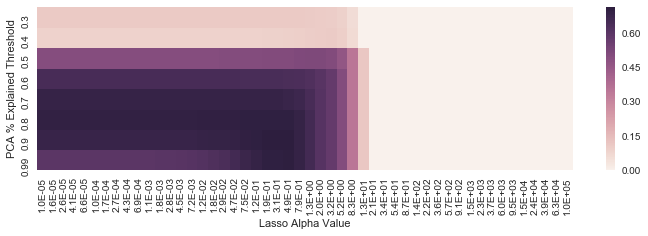

In [8]:
#means and SDs
means = pd.DataFrame(cv_scores.mean(axis=(0)), index=pca_values, columns=alpha_values)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.heatmap(means, xticklabels=[format(v, '1.1E') for v in alpha_values], ax=ax, vmin=0)
plt.xlabel('Lasso Alpha Value')
plt.ylabel('PCA % Explained Threshold')
plt.show()

In the above we see that that PCA percent of .8 and basically any alpha value works well, provided the alpha isn't too big. There is a severe cascade where incresing alpha reduces to guessing the mean of the trainng data, regardless of the PCA setting, earning a lower-than-zero R^2 score in the cv test set.

In [9]:
#get optimal params, fit to whole data

In [10]:
#[Do not open until Thursday: see how well we do on test]